<a href="https://colab.research.google.com/github/peruvianox/Vetta/blob/main/MagVect_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 KB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pingouin: filename=pingouin-0.5.3-py3-none-any.whl size=198588 sha256=3bbfc3ef458afb144a05f3d262e56966cb493c69eec89b700e803b1b2ccc8c64
  Stored in directory: /root/.cache/pip/wheels/60/1e/21/710be95d0c93ea9ac3c0e6bacd8cce492ad5dd26bf3aedc4bf
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7047 sha256=bc9bdc8002086b94e05784be99eea5e288ba010419dbebbd2240fb62ef9941cc
  Stored in directory: /root/.cache/pip/wheels/6a/33/c4/0ef84d7f5568c2823e3d63a6e08988852fb9e4bc822034870a
Successfully built pingouin littleuti

In [2]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 33.7 MB/s eta 0:00:00


In [3]:
import sklearn
print('sklearn version =', sklearn.__version__)

sklearn version = 1.2.0


In [4]:
from google.colab import drive
drive.mount("/content/drive")
import os
import re
import pandas as pd
import datetime as dt
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import signal
from scipy import interpolate
from google.colab import output
from sklearn import linear_model
from sklearn import metrics
import time 
from sklearn import svm
from sklearn.neural_network import MLPRegressor
import sqlite3
import pingouin as pg
DataFolder = '/content/drive/My Drive/EII-PGB/Data/SyncedData'
os.chdir(DataFolder)

plt.rcParams.update({'font.size': 15})

Mounted at /content/drive


# Load Subject Data

In [5]:
# ReProcess = 0

# if ReProcess == 0:
Data = pd.read_csv('FullData.csv').reset_index(drop=True)
Cols = Data.columns
Cols2Del = []
for i, c in enumerate(Cols): # identify unnamed columns
  if 'Unnamed' in c: 
    Cols2Del.append(c)
Data = Data.drop(columns=Cols2Del) # get rid of unnamed column

Meta = pd.read_csv('MetaData.csv').reset_index(drop=True)

# elif ReProcess == 1: # REPROCESS DATA

#   # make column names for dataframe
#   grf = []
#   Fc = []
#   Sc = []
#   Wc = []
#   Cc = []
#   for i in range(100):
#     grf.append('GRF' + str(i))
#     Fc.append('Foot' + str(i))
#     Sc.append('Shank' + str(i))
#     Wc.append('Waist' + str(i))
#     Cc.append('Torso' + str(i))

#   Cols = np.hstack([grf, Fc, Sc, Wc, Cc]) # join column lists together

#   # get list of table names
#   con = sqlite3.connect('steps.db')

#   def sql_fetch(con):
#     cur = con.cursor()
#     cur.execute('SELECT name FROM sqlite_master WHERE type="table"')
#     return list(cur.fetchall())

#   TableNames = sql_fetch(con)

#   # loop through all table names and extract steps
#   con = sqlite3.connect('steps.db')
#   Meta = pd.DataFrame(columns=['Subj', 'Cond', 'Side', 'Step'])
#   Data = pd.DataFrame(columns=Cols)
#   df = {}
#   for T in TableNames:
#     t = T[0]
#     i = int(t.split("_")[0][1:]) - 1
#     cur = con.cursor()
#     CuteStr = 'SELECT * FROM ' + t
#     cur.execute(CuteStr)
#     result_data = cur.fetchall()
#     cols = [description[0] for description in cur.description]
#     d = pd.DataFrame(result_data, columns=cols)

#     # perform vector magnidute combinations for each accelerometer
#     if '_L' in t: 
#       Foot = np.sqrt(d['LF_X']**2 + d['LF_Y']**2 + d['LF_Z']**2)  
#       Shank = np.sqrt(d['LS_X']**2 + d['LS_Y']**2 + d['LS_Z']**2)  
#       vGRF = d['GRF_Ly']
#     elif '_R' in t: 
#       Foot = np.sqrt(d['RF_X']**2 + d['RF_Y']**2 + d['RF_Z']**2)  
#       Shank = np.sqrt(d['RS_X']**2 + d['RS_Y']**2 + d['RS_Z']**2)  
#       vGRF = d['GRF_Ry'] 
        
#     Waist = np.sqrt(d['SAC_X']**2 + d['SAC_Y']**2 + d['SAC_Z']**2)  
#     Torso = np.sqrt(d['TOR_X']**2 + d['TOR_Y']**2 + d['TOR_Z']**2)     
    
#     Data.loc[len(Data) + 1] = np.hstack([vGRF, np.array(Foot), np.array(Shank), 
#                 np.array(Waist), np.array(Torso)])
    
#     Fname = t.split('_')
#     Meta.loc[len(Meta) + 1] = [Fname[0], Fname[1], Fname[2][0], Fname[2][1]]
#     # print('Saving Step: ' + t)

#   con.close()

#   Data.to_csv('FullData.csv')
#   Meta.to_csv('MetaData.csv')
#   print('All Data Loaded')

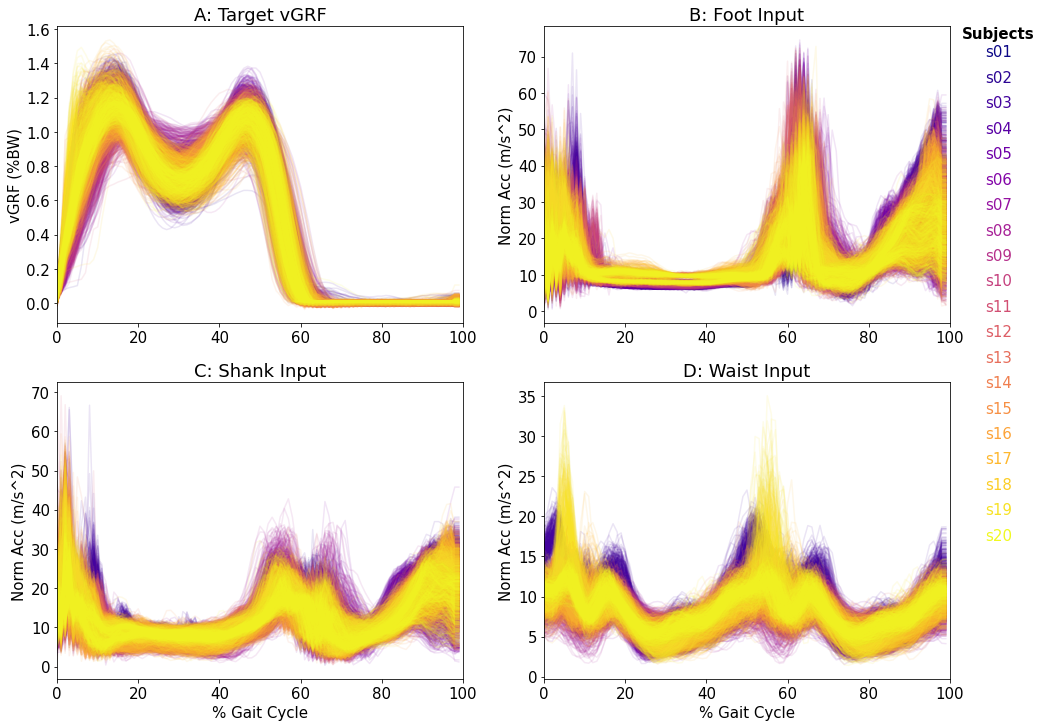

In [6]:
# plot acceleration data
Cols = Data.columns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
C = cm.get_cmap('plasma', 20)

Foot = Data[[x for x in Data.columns if 'Foot' in x]].to_numpy().T
Shank = Data[[x for x in Data.columns if 'Shank' in x]].to_numpy().T
Waist = Data[[x for x in Data.columns if 'Waist' in x]].to_numpy().T
vGRF = Data[[x for x in Data.columns if 'GRF' in x]].to_numpy().T

plt.figure(figsize=(16,12))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
A = 0.1

for r in range(len(Data)):
  i = int(Meta.Subj[r][1:])
  # plot all Acceleration signals
  ax1.plot(vGRF[:,r],'-k', c=C.colors[i-1], alpha=A)
  ax2.plot(Foot[:,r],'-k', c=C.colors[i-1], alpha=A)
  ax3.plot(Shank[:,r],'-k', c=C.colors[i-1], alpha=A)
  ax4.plot(Waist[:,r],'-k', c=C.colors[i-1], alpha=A)

# edit axes
ax1.set_title('A: Target vGRF')
ax1.set_xlim([0, 100])
ax1.set_ylabel('vGRF (%BW)')
ax2.set_title('B: Foot Input')
ax2.set_xlim([0, 100])
ax2.set_ylabel('Norm Acc (m/s^2)')
ax3.set_title('C: Shank Input')
ax3.set_xlim([0, 100])
ax3.set_ylabel('Norm Acc (m/s^2)')
ax3.set_xlabel('% Gait Cycle')
ax4.set_title('D: Waist Input')
ax4.set_xlim([0, 100])
ax4.set_ylabel('Norm Acc (m/s^2)')
ax4.set_xlabel('% Gait Cycle')

Subjs = np.unique(Meta.Subj)
ax2.text(112, 75, 'Subjects', c='k', ha='center', weight='bold')
for i in range(20):
  ax2.text(112, 70 - 7*i, Subjs[i], c=C.colors[i], ha='center')

plt.savefig('/content/drive/My Drive/EII-PGB/Data/SyncedData/FigFolder/Inputs.png')

# Get Parameters for Gait Event Detection

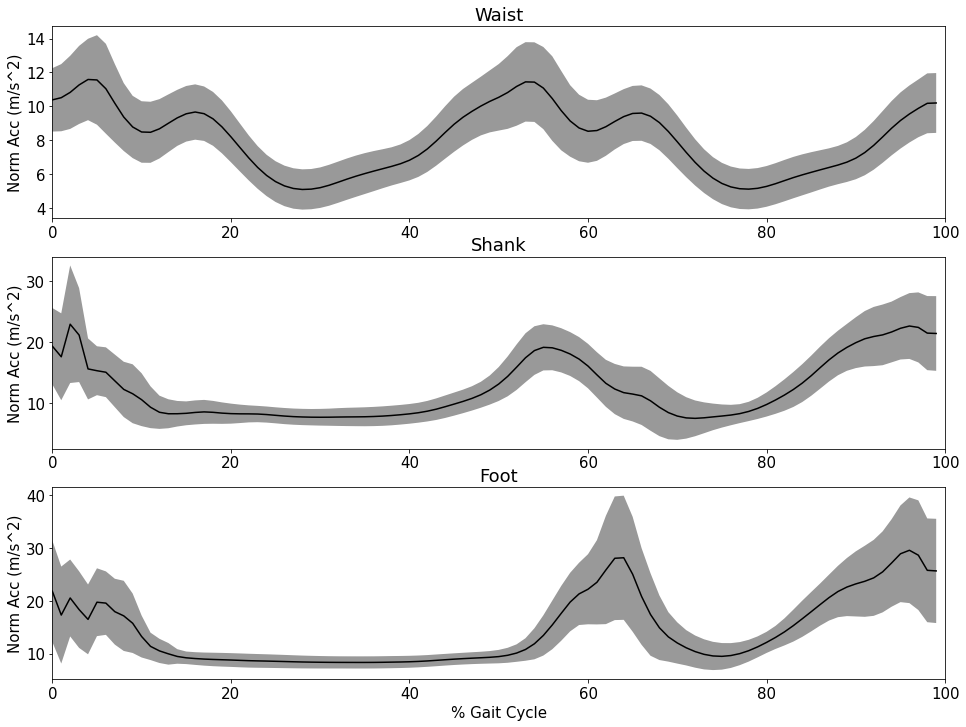

In [7]:
# plot mean Accs 

plt.figure(figsize=(16,12))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
LW = 3
A = 0.4

# fill in std area
y1 = np.mean(Waist, axis=1) + np.std(Waist, axis=1)
y2 = np.mean(Waist, axis=1) - np.std(Waist, axis=1)
ax1.fill_between(np.arange(len(y1)), y1, y2, fc='k', alpha = A)
y1 = np.mean(Shank, axis=1) + np.std(Shank, axis=1)
y2 = np.mean(Shank, axis=1) - np.std(Shank, axis=1)
ax2.fill_between(np.arange(len(y1)), y1, y2, fc='k', alpha = A)
y1 = np.mean(Foot, axis=1) + np.std(Foot, axis=1)
y2 = np.mean(Foot, axis=1) - np.std(Foot, axis=1)
ax3.fill_between(np.arange(len(y1)), y1, y2, fc='k', alpha = A)

# plot means
ax1.plot(np.mean(Waist, axis=1),'-k')
ax2.plot(np.mean(Shank, axis=1),'-k')
ax3.plot(np.mean(Foot, axis=1),'-k')

# edit axes
ax1.set_title('Waist')
ax1.set_xlim([0, 100])
ax1.set_ylabel('Norm Acc (m/s^2)')
ax2.set_title('Shank')
ax2.set_xlim([0, 100])
ax2.set_ylabel('Norm Acc (m/s^2)')
ax3.set_title('Foot')
ax3.set_xlim([0, 100])
ax3.set_ylabel('Norm Acc (m/s^2)')
ax3.set_xlabel('% Gait Cycle')

plt.savefig('/content/drive/My Drive/EII-PGB/Data/SyncedData/FigFolder/Input_Avgs.png')

# Define functions for processing

In [8]:
# define functions for processing later on
def ccc(x,y):
    ''' Concordance Correlation Coefficient'''
    x = np.array(x)
    y = np.array(y)
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc

def GetInds(Cols: list, Terms: list):
  # get indicies of terms in a list
  Inds = []
  for i, c in enumerate(Cols): 
    for q in Terms: 
      if re.match(q, c):
        Inds.append(i-1)

  return Inds

from matplotlib import cm
cmap = cm.rainbow(np.linspace(0, 1, 20))
plt.style = 'seaborn'

# Predict full waveform

MLP Neural Network

In [9]:
MLP = {}
plt.figure(figsize=(10,10))
models = ['FSW', 'FW', 'SW', 'FS', 'S', 'F', 'W']
AggMLP = {}


for model in models:
    plt.clf()
    if model == 'Full':
        Inputs = GetInds(Cols, ['Foot','Shank','Thigh','Waist','Torso'])
    elif model == 'FSW':
        Inputs = GetInds(Cols, ['Foot','Shank','Waist'])
    elif model == 'FW':
        Inputs = GetInds(Cols, ['Foot','Waist'])
    elif model == 'SW':
        Inputs = GetInds(Cols, ['Shank','Waist'])
    elif model == 'FS':
        Inputs = GetInds(Cols, ['Foot','Shank'])
    elif model == 'S':
        Inputs = GetInds(Cols, ['Shank'])
    elif model == 'F':
        Inputs = GetInds(Cols, ['Foot'])
    elif model == 'W':
        Inputs = GetInds(Cols, ['Waist'])

    
    AggMLP[model] = {}

    # implement K-fold cross validation for splitting testing & training inputs
    from sklearn.model_selection import KFold
    X = Data.iloc[:,100:]
    y = Data.iloc[:,0:99]
    S = np.unique(Meta['Subj'])

    # split based on subject indexes
    kf = KFold(n_splits=5)
    k = 0

    
    for TrainSubj, TestSubj in kf.split(S):
      print('Iteration: ' + str(k))
      # print('Training on: ', S[TrainSubj])
      # print('Testing on: ', S[TestSubj])

      TrainInds = [i for i, x in enumerate(Meta['Subj']) if x in S[TrainSubj]]
      TestInds = [i for i, x in enumerate(Meta['Subj']) if x in S[TestSubj]]

      # specify testing & training sets
      X_train = Data.iloc[TrainInds, Inputs]
      Y_train = Data.iloc[TrainInds,0:99]
      X_test = Data.iloc[TestInds, Inputs]
      Y_test = Data.iloc[TestInds,0:99]

      Meta_train = Meta.iloc[TrainInds]
      Meta_test = Meta.iloc[TestInds]

      # MLP
      MLP[model] = {}
      # clf = MLPRegressor(random_state=1, max_iter=500, verbose=False, activation='logistic')
      clf = MLPRegressor(random_state=1, max_iter=500, verbose=False, activation='logistic', hidden_layer_sizes=[200])
      start = time.time()
      clf.fit(X_train,Y_train) # Fit model
      MLP_P = clf.predict(X_test) # predict
      finish = time.time()
      MLP[model]['Model'] = clf

      # save outputs
      MLP[model]['Training Time'] = finish-start
      MLP[model]['RMSE'] = np.sqrt(metrics.mean_absolute_error(Y_test, MLP_P))
      MLP[model]['MAE'] = metrics.mean_absolute_error(Y_test, MLP_P)
      MLP[model]['R^2'] = metrics.r2_score(Y_test, MLP_P)
      MLP[model]['CCC'] = round(ccc(Y_test, MLP_P), 4)
      MLP[model]['Prediction'] = MLP_P
      MLP[model]['True'] = np.array(Y_test)
      MLP[model]['Test Metadata'] = Meta_test
      MLP[model]['Train Metadata'] = Meta_train
      MLP[model]['Test Input'] = np.array(X_test)

      # print results
      print('MLP Model: ' + model)
      print('MAE = ' + str(MLP[model]['MAE']))
      print('')

      # save model accuracy for each iteration & model
      AggMLP[model][k] = MLP[model]
      k += 1

Iteration: 0
MLP Model: FSW
MAE = 0.04132513557731298

Iteration: 1
MLP Model: FSW
MAE = 0.05103493558697768

Iteration: 2
MLP Model: FSW
MAE = 0.04199229427597927

Iteration: 3
MLP Model: FSW
MAE = 0.05204521684604452

Iteration: 4
MLP Model: FSW
MAE = 0.04819841079683048

Iteration: 0
MLP Model: FW
MAE = 0.0414634281180249

Iteration: 1
MLP Model: FW
MAE = 0.04563600623235218

Iteration: 2
MLP Model: FW
MAE = 0.04053612827209908

Iteration: 3
MLP Model: FW
MAE = 0.043627778264405274

Iteration: 4
MLP Model: FW
MAE = 0.045409356463546144

Iteration: 0
MLP Model: SW
MAE = 0.037865544890922025

Iteration: 1
MLP Model: SW
MAE = 0.05928622855725588

Iteration: 2
MLP Model: SW
MAE = 0.038339689994176675

Iteration: 3
MLP Model: SW
MAE = 0.04141257525277175

Iteration: 4
MLP Model: SW
MAE = 0.046487573716955506

Iteration: 0
MLP Model: FS
MAE = 0.04734820260175062

Iteration: 1
MLP Model: FS
MAE = 0.0625193378637258

Iteration: 2
MLP Model: FS
MAE = 0.047071810728862816

Iteration: 3
MLP Mo

<Figure size 720x720 with 0 Axes>

# Plot Results

FSW 4.692
FW 4.333
SW 4.468
FS 5.338
S 4.948
F 4.858
W 3.996


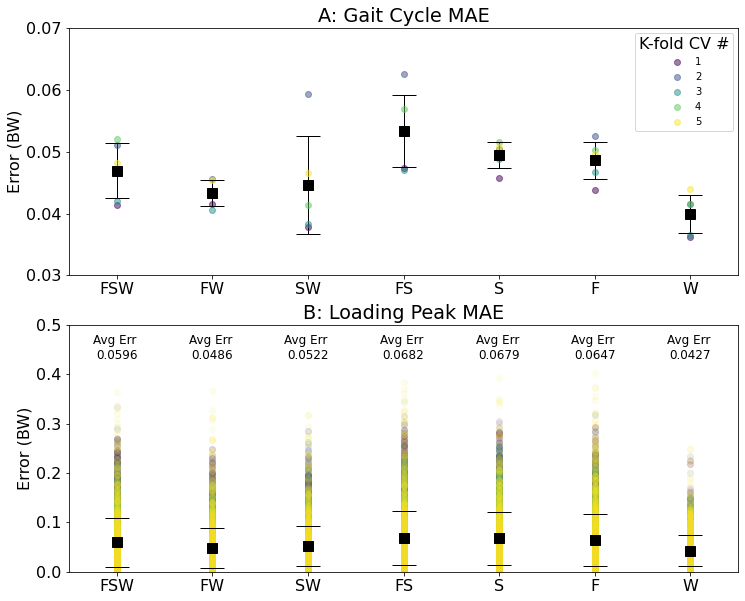

In [45]:
os.chdir('/content/drive/My Drive/EII-PGB/Data/SyncedData/FigFolder')

plt.figure(figsize=(12, 10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

# plot whole stance MAE
C = cm.get_cmap('viridis', 5)
AvgError = {}
StdError = {}
A1 = 0.5

for Ind, model in enumerate(models):
  AvgError[model] = []
  StdError[model] = []
  for i, x in enumerate(AggMLP[model]):

    if Ind == 0:
      ax1.plot(Ind, AggMLP[model][i]['MAE'], 'o', c=C.colors[i], label=i+1, alpha = A1)
    else:
      ax1.plot(Ind, AggMLP[model][i]['MAE'], 'o', c=C.colors[i], alpha = A1)

    AvgError[model].append(np.mean(AggMLP[model][i]['MAE']))
    StdError[model].append(np.std(AggMLP[model][i]['MAE']))

  # plot average error
  ax1.errorbar(Ind, np.mean(AvgError[model]), np.std(AvgError[model]), ms=10,
               fmt='sk', ecolor='k', elinewidth=1, capsize=12)
  print(model, str(round(100 * np.mean(AvgError[model]), 3)))

ax1.legend(fontsize=10, title='K-fold CV #')
ax1.set_xticks(range(len(models)))
ax1.set_yticks([0.03, 0.04, 0.05, 0.06, 0.07])
ax1.set_xticklabels(models)
ax1.set_ylabel('Error (BW)')
ax1.set_title('A: Gait Cycle MAE')
ax1.set_xlim([-0.5, 6.5])


# get loading peak error
AvgError = {}
StdError = {}
for Ind, model in enumerate(models):
  AvgError[model] = []
  StdError[model] = []
  for i, x in enumerate(AggMLP[model]):
    AggMLP[model][i]['TruePk'] = np.zeros((len(AggMLP[model][i]['True']),1))
    AggMLP[model][i]['PredPk'] = np.zeros((len(AggMLP[model][i]['Prediction']),1))
    AggMLP[model][i]['PkErr'] = np.zeros((len(AggMLP[model][i]['Prediction']),1))

    
    for r in range(len(AggMLP[model][i]['Prediction'])):
      AggMLP[model][i]['TruePk'][r] = np.max(AggMLP[model][i]['True'][r, 0:50])
      AggMLP[model][i]['PredPk'][r] = np.max(AggMLP[model][i]['Prediction'][r, 0:50])
      AggMLP[model][i]['PkErr'][r] = abs(AggMLP[model][i]['TruePk'][r] - AggMLP[model][i]['PredPk'][r])

      plt.plot(Ind, AggMLP[model][i]['PkErr'][r], 'o', c=C.colors[i], alpha=A)
  
    AvgError[model].append(np.mean(AggMLP[model][i]['PkErr']))
    StdError[model].append(np.std(AggMLP[model][i]['PkErr']))

  # plot average error
  ax2.errorbar(Ind, np.mean(AvgError[model]), np.mean(StdError[model]), ms=10,
               fmt='sk', ecolor='k', elinewidth=1, capsize=12)

  ax2.text(Ind, 0.43, 'Avg Err \n' + str(round(np.mean(AvgError[model]),4)), ha='center', fontsize=12)

ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models)
ax2.set_ylabel('Error (BW)')
ax2.set_title('B: Loading Peak MAE')
ax2.set_xlim([-0.5, 6.5])
ax2.set_ylim([0, 0.5])

plt.savefig('MAE.png')

FSW
FW
SW
FS
S
F
W


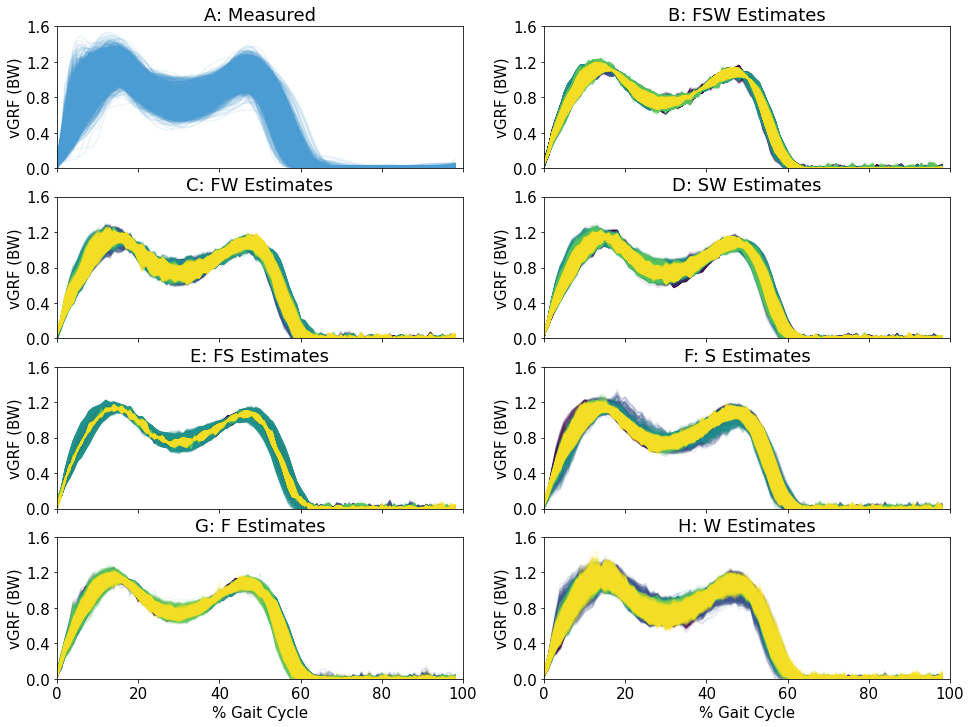

In [11]:
# plot all raw predicitons
os.chdir('/content/drive/My Drive/EII-PGB/Data/SyncedData/FigFolder')

A = 0.1
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
C = cm.get_cmap('viridis', 5)

# plot true
plt.figure(figsize=(16, 12))
ax1 = plt.subplot(4, 2, 1)
plt.title('A: Measured')
for i, x in enumerate(AggMLP[model]):
  plt.plot(AggMLP[model][i]['True'][:, :].T, '-k', alpha=A, c=(75/255, 156/255, 211/255)) 
plt.ylabel('vGRF (BW)')
# plt.xlabel('% Stance Phase')
plt.ylim((0, 1.6))
plt.yticks([0, 0.4, 0.8, 1.2, 1.6])
plt.xlim((0, 100))
plt.xticks([0, 20, 40, 60, 80, 100], labels = [])
Letter = ['B','C','D','E','F','G','H']

for j, model in enumerate(models):
  ax = plt.subplot(4, 2, j + 2)
  print(model)
  for i, x in enumerate(AggMLP[model]):
    ax.plot(AggMLP[model][i]['Prediction'].T, '-k', alpha=A,  c = C.colors[i,:]) #c=(75/255, 156/255, 211/255))

  ax.set_title(Letter[j] + ': ' + model + ' Estimates')
  ax.set_ylabel('vGRF (BW)')
  
  ax.set_ylim((0, 1.6))
  ax.set_yticks([0, 0.4, 0.8, 1.2, 1.6])
  ax.set_xlim((0, 100))
  ax.set_xticks([0, 20, 40, 60, 80, 100])
  ax.set_xticklabels([])

  if j == 5 or j == 6:
    ax.set_xticklabels([0, 20, 40, 60, 80, 100])
    ax.set_xlabel('% Gait Cycle')

plt.savefig('MeasuredAndPredictions.png')

FSW
FW
SW
FS
S
F
W


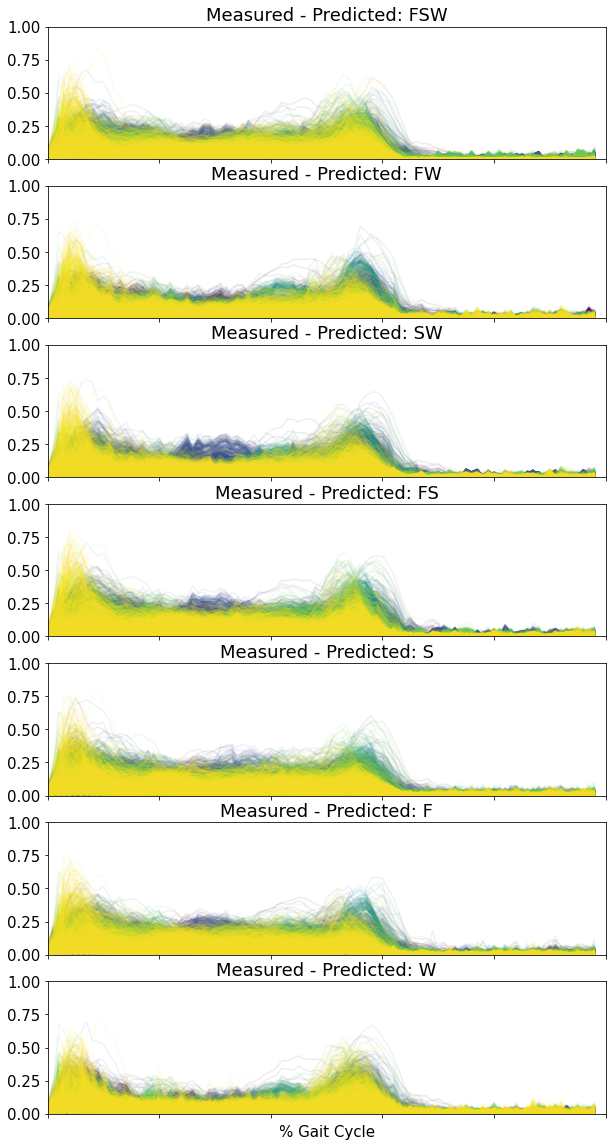

In [12]:
# plot differences 
A = 0.08
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
C = cm.get_cmap('viridis', 5)
plt.figure(figsize=(10, 20))

for Ind, model in enumerate(models):
  print(model)
  ax = plt.subplot(7, 1, Ind+1)
  for i, x in enumerate(AggMLP[model]):
    for r in range(len(AggMLP[model][i]['Prediction'])):
      y = AggMLP[model][i]['True'][r, :] - AggMLP[model][i]['Prediction'][r, :]
      ax.plot(abs(y), '-k', alpha=A, c=C.colors[i,:])

  ax.set_title('Measured - Predicted: ' + model)
  ax.set_ylim((0,1))
  ax.set_xticklabels('')
  ax.set_xlim((0,100))
ax.set_xlabel('% Gait Cycle')
plt.savefig('Differences.png')

In [13]:
# create dataframe of subject average waveforms
model = 'W'
colnames = []
for x in range(99):
  colnames.append('grf'+str(x))
C = ['Subj','Cond'] + colnames
Conds = ['control', 'over', 'under']
SubMLP = {}
SubAvgsP = pd.DataFrame(columns=C)
SubAvgsT = pd.DataFrame(columns=C)
SubAvgsMAE = pd.DataFrame(columns=C)
SubPkP = pd.DataFrame(columns=['Subj','Cond', 'Sys','vGRF'])
SubPkT = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
SubPkMAE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
j = 0
for i in range(len(AggMLP[model])):
  M = AggMLP[model][i]['Test Metadata']

  for S in np.unique(M['Subj']): 
    SubMLP[S] = {}
    for C in Conds:
      SubMLP[S][C] = {}
      SubjInds = [x for x, z in enumerate(M['Subj'].tolist()) if z == S]
      CondInds = [x for x, z in enumerate(M['Cond'].tolist()) if z == C]
      match = list(set(SubjInds) & set(CondInds))
      match.sort()

      # save full waveform
      SubMLP[S][C]['Pred'] = np.mean(AggMLP[model][i]['Prediction'][match, :], axis=0)
      SubMLP[S][C]['True'] = np.mean(AggMLP[model][i]['True'][match, :], axis=0)
      SubMLP[S][C]['StanceErr'] = abs(SubMLP[S][C]['Pred'] - SubMLP[S][C]['True'])

      SubAvgsP.loc[j] = np.hstack([S, C, SubMLP[S][C]['Pred']])
      SubAvgsT.loc[j] = np.hstack([S, C, SubMLP[S][C]['True']])
      SubAvgsMAE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceErr']])

      # save loading peak & error
      SubMLP[S][C]['PredPk'] = np.mean(AggMLP[model][i]['PredPk'][match, :], axis=0)
      SubMLP[S][C]['TruePk'] = np.mean(AggMLP[model][i]['TruePk'][match, :], axis=0)
      SubMLP[S][C]['PkErr'] = np.mean(AggMLP[model][i]['PkErr'][match, :], axis=0)

      SubPkP.loc[j] = [S, C, 'Pred', SubMLP[S][C]['PredPk'][0]]
      SubPkT.loc[j] = [S, C, 'True', SubMLP[S][C]['TruePk'][0]]
      SubPkMAE.loc[j] = [S, C, SubMLP[S][C]['PkErr'][0]]

      j += 1

SubPks = pd.concat([SubPkP, SubPkT], axis=0)

# Run Statistics

## Waist Model 

In [14]:
# create dataframe of subject average waveforms
model = 'W'
colnames = []
for x in range(99):
  colnames.append('grf'+str(x))
C = ['Subj','Cond'] + colnames
Conds = ['control', 'over', 'under']
SubMLP = {}
SubAvgsP = pd.DataFrame(columns=C)
SubAvgsT = pd.DataFrame(columns=C)
SubAvgsMAE = pd.DataFrame(columns=C)
SubAvgsRMSE = pd.DataFrame(columns=C)
SubPkP = pd.DataFrame(columns=['Subj','Cond', 'Sys','vGRF'])
SubPkT = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
SubPkMAE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
SubPkRMSE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
j = 0
for i in range(len(AggMLP[model])):
  M = AggMLP[model][i]['Test Metadata']

  for S in np.unique(M['Subj']): 
    SubMLP[S] = {}
    for C in Conds:
      SubMLP[S][C] = {}
      SubjInds = [x for x, z in enumerate(M['Subj'].tolist()) if z == S]
      CondInds = [x for x, z in enumerate(M['Cond'].tolist()) if z == C]
      match = list(set(SubjInds) & set(CondInds))
      match.sort()

      # save full waveform
      SubMLP[S][C]['Pred'] = np.mean(AggMLP[model][i]['Prediction'][match, :], axis=0)
      SubMLP[S][C]['True'] = np.mean(AggMLP[model][i]['True'][match, :], axis=0)
      SubMLP[S][C]['StanceErr'] = abs(SubMLP[S][C]['Pred'] - SubMLP[S][C]['True'])
      SubMLP[S][C]['StanceMAE'] = np.mean(abs(AggMLP[model][i]['Prediction'][match, :] - AggMLP[model][i]['True'][match, :]), axis=0)
      SubMLP[S][C]['StanceRMSE'] = np.sqrt(np.mean((AggMLP[model][i]['Prediction'][match, :] - AggMLP[model][i]['True'][match, :])**2, axis=0))

      SubAvgsP.loc[j] = np.hstack([S, C, SubMLP[S][C]['Pred']])
      SubAvgsT.loc[j] = np.hstack([S, C, SubMLP[S][C]['True']])
      SubAvgsMAE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceMAE']])
      SubAvgsRMSE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceRMSE']])

      # save loading peak & error
      SubMLP[S][C]['PredPk'] = np.mean(AggMLP[model][i]['PredPk'][match, :], axis=0)
      SubMLP[S][C]['TruePk'] = np.mean(AggMLP[model][i]['TruePk'][match, :], axis=0)
      SubMLP[S][C]['PkErr'] = np.mean(AggMLP[model][i]['PkErr'][match, :], axis=0)
      SubMLP[S][C]['PkMAE'] = np.mean(abs(AggMLP[model][i]['PredPk'][match, :] - AggMLP[model][i]['TruePk'][match, :]))
      SubMLP[S][C]['PkRMSE'] = np.sqrt(np.mean((AggMLP[model][i]['PredPk'][match, :] - AggMLP[model][i]['TruePk'][match, :])**2))
      
      SubPkP.loc[j] = [S, C, 'Pred', SubMLP[S][C]['PredPk'][0]]
      SubPkT.loc[j] = [S, C, 'True', SubMLP[S][C]['TruePk'][0]]
      SubPkMAE.loc[j] = [S, C, SubMLP[S][C]['PkMAE']]
      SubPkRMSE.loc[j] = [S, C, SubMLP[S][C]['PkRMSE']]

      j += 1

SubPks = pd.concat([SubPkP, SubPkT], axis=0)

In [15]:
pg.rm_anova(SubPks, dv='vGRF', within=['Sys','Cond'], subject='Subj', effsize = 'np2').round(3)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Sys,0.003,1,19,0.003,2.142,0.160,0.160,0.101,1.000
1,Cond,0.142,2,38,0.071,48.502,0.000,0.000,0.719,0.806
2,Sys * Cond,0.001,2,38,0.001,1.945,0.157,0.162,0.093,0.908


In [16]:
# Tukey's post hoc between Pred conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', between='Cond', effsize='eta-square')

/usr/local/lib/python3.8/dist-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,control,over,1.161109,1.205061,-0.043952,0.016709,-2.630486,0.029041,0.130980
1,control,under,1.161109,1.128737,0.032372,0.016709,1.937412,0.137561,0.097999
2,over,under,1.205061,1.128737,0.076324,0.016709,4.567898,0.000079,0.345411


In [17]:
# Tukey's post hoc between Meas conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', between='Cond', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,control,over,1.168240,1.224299,-0.056059,0.018321,-3.059870,0.009312,0.176951
1,control,under,1.168240,1.132886,0.035354,0.018321,1.929769,0.139639,0.101572
2,over,under,1.224299,1.132886,0.091413,0.018321,4.989639,0.000018,0.363944


In [18]:
# Tukey's post hoc between Meas & Pred - Control Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', between='Sys', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,Pred,True,1.161109,1.16824,-0.007131,0.016767,-0.42532,0.673003,0.004502


In [19]:
# Tukey's post hoc between Meas & PredP - Over Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', between='Sys', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,Pred,True,1.205061,1.224299,-0.019238,0.020117,-0.956285,0.344973,0.022351


In [20]:
# Tukey's post hoc between Meas & Pred - Under Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', between='Sys', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,Pred,True,1.128737,1.132886,-0.004149,0.015375,-0.26984,0.788743,0.001817


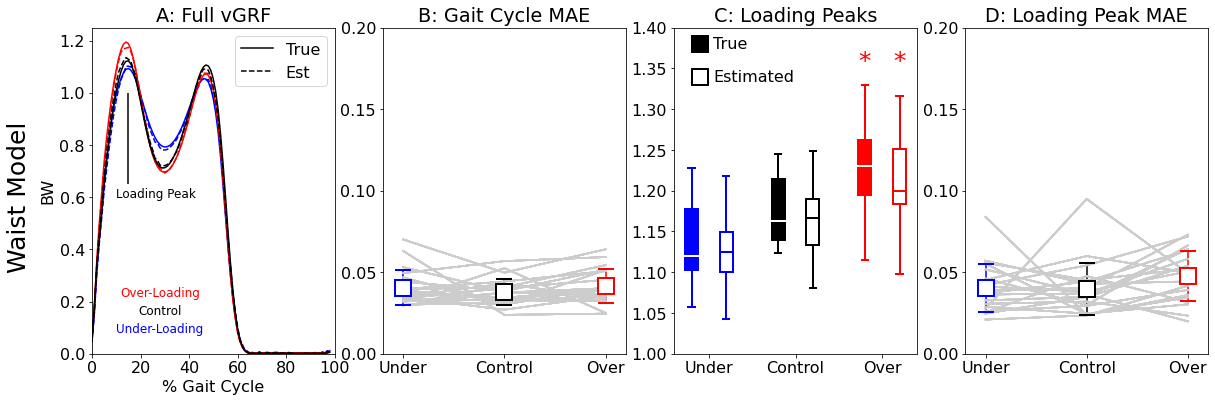

In [21]:
# Plot Results figures
fnt = 16
plt.rcParams.update({'font.size': fnt})
fig = plt.figure(figsize=(20,6))

# plot full vGRF waveform
ax1 = plt.subplot(141)
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '-b')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '--b')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '-r')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '--r')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '-k', label='True')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '--k', label='Est')
ax1.set_title('A: Full vGRF')
ax1.legend(loc='upper right')
ax1.set_ylim([0, 1.25])
ax1.set_xlim([0, 100])
ax1.set_xlabel('% Gait Cycle')
ax1.set_ylabel('BW')
ax1.text(28, 0.22, 'Over-Loading', c='r', ha='center', fontsize=12)
ax1.text(28, 0.15, 'Control', c='k', ha='center', fontsize=12)
ax1.text(28, 0.08, 'Under-Loading', c='b', ha='center', fontsize=12)
ax1.vlines(15, 0.65, 1)
ax1.text(10, 0.60, 'Loading Peak', fontsize=12)
ax1.text(-30, 0.60, 'Waist Model', fontsize=25, ha='center', va='center', rotation='vertical')


# plot predicted & true peaks
ax2 = plt.subplot(143)
ht = 0.5
p = 0

# under
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'under'].vGRF, 
            positions=[0.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'b', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'under'].vGRF, 
            positions=[1.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "b", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

# control
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'control'].vGRF, 
            positions=[1.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'k', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'control'].vGRF, 
            positions=[2.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "k", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

# over
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'over'].vGRF, 
            positions=[2.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'r', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})
ax2.boxplot(SubPkP[SubPkP['Cond'] == 'over'].vGRF, 
            positions=[3.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "r", "linewidth": 2},
            boxprops={"facecolor": 'white', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})

ax2.set_xticks(ticks=[1, 2, 3]) 
ax2.set_xticklabels(['Under', 'Control', 'Over'])
ax2.set_title('C: Loading Peaks')
ax2.set_xlim([0.6, 3.4])
ax2.set_ylim([1, 1.4])
ax2.text(3.2, 1.35, '*', color='r', fontsize=25, ha='center') # add statistical differences
ax2.text(2.8,1.35, '*', color='r', fontsize=25, ha='center')
ax2.plot(0.9, 1.38, 'sk', mfc='k', ms=16, mew=2)
ax2.text(1.05, 1.38, 'True', va='center')
ax2.plot(0.9, 1.34, 'sk', mfc='w', ms=16, mew=2)
ax2.text(1.05, 1.34, 'Estimated', va='center')


# Plot Stance Average Error 
ax=plt.subplot(142)
for k in range(len(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'])):
  ax.plot([1,2,3], [np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1), 
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1), 
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1)], 
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax.errorbar([1], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([2], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([3], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax.set_xticks([1,2,3])
ax.set_xticklabels(['Under', 'Control', 'Over'])
ax.set_xlim([0.8, 3.2])
ax.set_ylim([0, 0.2])
ax.set_yticks([0,0.05,0.10, 0.15, 0.2])
ax.set_title('B: Gait Cycle MAE')

# plot peak average error
ax4=plt.subplot(144)
for k in range(len(SubPkT[SubPkT['Cond'] == 'control'])):
  ax4.plot([1,2,3], [SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF, 
                    SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF, 
                    SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF], 
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax4.errorbar([1], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([2], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([3], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax4.set_xticks([1,2,3])
ax4.set_xticklabels(['Under', 'Control', 'Over'])
ax4.set_xlim([0.8, 3.2])
ax4.set_ylim([0, 0.2])
ax4.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax4.set_title('D: Loading Peak MAE')
plt.savefig('W_sensitivity.png')

In [22]:
# output average errors by condition
Ue = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('GC Under MAE:', round(100*Ue, 2), ' %BW')
print('GC Control MAE:', round(100*Ce, 2), ' %BW')
print('GC Over MAE:', round(100*Oe, 2), ' %BW')

Ue = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('GC Under RMSE:', round(100*Ue, 2), ' %BW')
print('GC Control RMSE:', round(100*Ce, 2), ' %BW')
print('GC Over RMSE:', round(100*Oe, 2), ' %BW')
print(' ')

Ue = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Pk Under MAE:', round(100*Ue, 2), ' %BW')
print('Pk Control MAE:', round(100*Ce, 2), ' %BW')
print('Pk Over MAE:', round(100*Oe, 2), ' %BW')

Ue = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Pk Under RMSE:', round(100*Ue, 2), ' %BW')
print('Pk Control RMSE:', round(100*Ce, 2), ' %BW')
print('Pk Over RMSE:', round(100*Oe, 2), ' %BW')


GC Under MAE: 4.06  %BW
GC Control MAE: 3.78  %BW
GC Over MAE: 4.14  %BW
GC Under RMSE: 4.84  %BW
GC Control RMSE: 4.43  %BW
GC Over RMSE: 4.98  %BW
 
Pk Under MAE: 4.04  %BW
Pk Control MAE: 3.99  %BW
Pk Over MAE: 4.77  %BW
Pk Under RMSE: 4.83  %BW
Pk Control RMSE: 4.64  %BW
Pk Over RMSE: 5.74  %BW


## Foot-Waist model

In [23]:
# create dataframe of subject average waveforms
model = 'FW'
colnames = []
for x in range(99):
  colnames.append('grf'+str(x))
C = ['Subj','Cond'] + colnames
Conds = ['control', 'over', 'under']
SubMLP = {}
SubAvgsP = pd.DataFrame(columns=C)
SubAvgsT = pd.DataFrame(columns=C)
SubAvgsMAE = pd.DataFrame(columns=C)
SubAvgsRMSE = pd.DataFrame(columns=C)
SubPkP = pd.DataFrame(columns=['Subj','Cond', 'Sys','vGRF'])
SubPkT = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
SubPkMAE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
SubPkRMSE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
j = 0
for i in range(len(AggMLP[model])):
  M = AggMLP[model][i]['Test Metadata']

  for S in np.unique(M['Subj']): 
    SubMLP[S] = {}
    for C in Conds:
      SubMLP[S][C] = {}
      SubjInds = [x for x, z in enumerate(M['Subj'].tolist()) if z == S]
      CondInds = [x for x, z in enumerate(M['Cond'].tolist()) if z == C]
      match = list(set(SubjInds) & set(CondInds))
      match.sort()

      # save full waveform
      SubMLP[S][C]['Pred'] = np.mean(AggMLP[model][i]['Prediction'][match, :], axis=0)
      SubMLP[S][C]['True'] = np.mean(AggMLP[model][i]['True'][match, :], axis=0)
      SubMLP[S][C]['StanceErr'] = abs(SubMLP[S][C]['Pred'] - SubMLP[S][C]['True'])
      SubMLP[S][C]['StanceMAE'] = np.mean(abs(AggMLP[model][i]['Prediction'][match, :] - AggMLP[model][i]['True'][match, :]), axis=0)
      SubMLP[S][C]['StanceRMSE'] = np.sqrt(np.mean((AggMLP[model][i]['Prediction'][match, :] - AggMLP[model][i]['True'][match, :])**2, axis=0))

      SubAvgsP.loc[j] = np.hstack([S, C, SubMLP[S][C]['Pred']])
      SubAvgsT.loc[j] = np.hstack([S, C, SubMLP[S][C]['True']])
      SubAvgsMAE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceMAE']])
      SubAvgsRMSE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceRMSE']])

      # save loading peak & error
      SubMLP[S][C]['PredPk'] = np.mean(AggMLP[model][i]['PredPk'][match, :], axis=0)
      SubMLP[S][C]['TruePk'] = np.mean(AggMLP[model][i]['TruePk'][match, :], axis=0)
      SubMLP[S][C]['PkErr'] = np.mean(AggMLP[model][i]['PkErr'][match, :], axis=0)
      SubMLP[S][C]['PkMAE'] = np.mean(abs(AggMLP[model][i]['PredPk'][match, :] - AggMLP[model][i]['TruePk'][match, :]))
      SubMLP[S][C]['PkRMSE'] = np.sqrt(np.mean((AggMLP[model][i]['PredPk'][match, :] - AggMLP[model][i]['TruePk'][match, :])**2))
      
      SubPkP.loc[j] = [S, C, 'Pred', SubMLP[S][C]['PredPk'][0]]
      SubPkT.loc[j] = [S, C, 'True', SubMLP[S][C]['TruePk'][0]]
      SubPkMAE.loc[j] = [S, C, SubMLP[S][C]['PkMAE']]
      SubPkRMSE.loc[j] = [S, C, SubMLP[S][C]['PkRMSE']]

      j += 1

SubPks = pd.concat([SubPkP, SubPkT], axis=0)

In [24]:
import pingouin as pg
pg.rm_anova(SubPks, dv='vGRF', within=['Sys','Cond'], subject='Subj', effsize = 'np2').round(3)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Sys,0.010,1,19,0.010,5.593,0.029,0.029,0.227,1.000
1,Cond,0.108,2,38,0.054,49.440,0.000,0.000,0.722,0.763
2,Sys * Cond,0.008,2,38,0.004,9.445,0.000,0.001,0.332,0.833


In [25]:
# Tukey's post hoc between Pred conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', between='Cond', effsize='eta-square')

/usr/local/lib/python3.8/dist-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,control,over,1.159341,1.183792,-0.024451,0.011466,-2.132433,0.092278,0.106795
1,control,under,1.159341,1.128680,0.030662,0.011466,2.674061,0.026021,0.149433
2,over,under,1.183792,1.128680,0.055113,0.011466,4.806494,0.000034,0.358903


In [26]:
# Tukey's post hoc between Meas conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', between='Cond', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,control,over,1.168240,1.224299,-0.056059,0.018321,-3.059870,0.009312,0.176951
1,control,under,1.168240,1.132886,0.035354,0.018321,1.929769,0.139639,0.101572
2,over,under,1.224299,1.132886,0.091413,0.018321,4.989639,0.000018,0.363944


In [27]:
# Tukey's post hoc between Meas & Pred - Control Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', between='Sys', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,Pred,True,1.159341,1.16824,-0.008899,0.01414,-0.629374,0.53287,0.009806


In [28]:
# Tukey's post hoc between Meas & PredP - Over Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', between='Sys', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,Pred,True,1.183792,1.224299,-0.040507,0.017044,-2.376594,0.022615,0.123733


In [29]:
# Tukey's post hoc between Meas & Pred - Under Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', between='Sys', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,Pred,True,1.12868,1.132886,-0.004206,0.0145,-0.290089,0.773325,0.002099


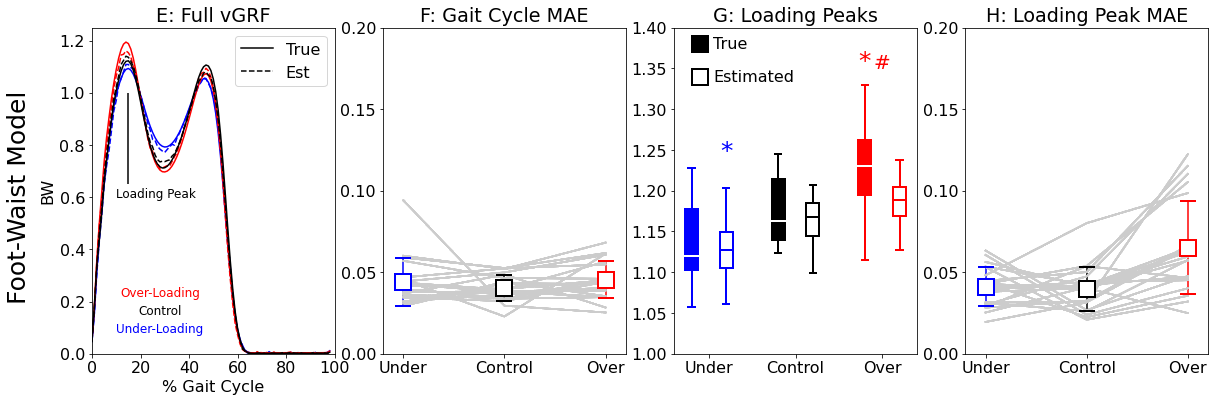

In [30]:
# Plot Results figures
fnt = 16
plt.rcParams.update({'font.size': fnt})
fig = plt.figure(figsize=(20,6))

# plot full vGRF waveform
ax1 = plt.subplot(141)
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '-b')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '--b')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '-r')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '--r')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '-k', label='True')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '--k', label='Est')
ax1.set_title('E: Full vGRF')
ax1.legend(loc='upper right')
ax1.set_ylim([0, 1.25])
ax1.set_xlim([0, 100])
ax1.set_xlabel('% Gait Cycle')
ax1.set_ylabel('BW')
ax1.text(28, 0.22, 'Over-Loading', c='r', ha='center', fontsize=12)
ax1.text(28, 0.15, 'Control', c='k', ha='center', fontsize=12)
ax1.text(28, 0.08, 'Under-Loading', c='b', ha='center', fontsize=12)
ax1.vlines(15, 0.65, 1)
ax1.text(10, 0.60, 'Loading Peak', fontsize=12)
ax1.text(-30, 0.60, 'Foot-Waist Model', fontsize=25, ha='center', va='center', rotation='vertical')


# plot predicted & true peaks
ax2 = plt.subplot(143)
ht = 0.5
p = 0

# under
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'under'].vGRF, 
            positions=[0.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'b', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'under'].vGRF, 
            positions=[1.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "b", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

# control
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'control'].vGRF, 
            positions=[1.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'k', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'control'].vGRF, 
            positions=[2.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "k", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

# over
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'over'].vGRF, 
            positions=[2.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'r', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})
ax2.boxplot(SubPkP[SubPkP['Cond'] == 'over'].vGRF, 
            positions=[3.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "r", "linewidth": 2},
            boxprops={"facecolor": 'white', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})

ax2.set_xticks(ticks=[1, 2, 3]) 
ax2.set_xticklabels(['Under', 'Control', 'Over'])
ax2.set_title('G: Loading Peaks')
ax2.set_xlim([0.6, 3.4])
ax2.set_ylim([1, 1.4])
ax2.text(1.2, 1.24, '*', color='b', fontsize=25, ha='center')
ax2.text(2.8, 1.35, '*', color='r', fontsize=25, ha='center')
ax2.text(3, 1.35, '#', color='r', fontsize=20, ha='center')
ax2.plot(0.9, 1.38, 'sk', mfc='k', ms=16, mew=2)
ax2.text(1.05, 1.38, 'True', va='center')
ax2.plot(0.9, 1.34, 'sk', mfc='w', ms=16, mew=2)
ax2.text(1.05, 1.34, 'Estimated', va='center')


# Plot Stance Average Error 
ax=plt.subplot(142)
for k in range(len(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'])):
  ax.plot([1,2,3], [np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1), 
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1), 
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1)], 
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax.errorbar([1], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([2], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([3], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax.set_xticks([1,2,3])
ax.set_xticklabels(['Under', 'Control', 'Over'])
ax.set_xlim([0.8, 3.2])
ax.set_ylim([0, 0.2])
ax.set_yticks([0,0.05,0.10, 0.15, 0.2])
ax.set_title('F: Gait Cycle MAE')

# plot peak average error
ax4=plt.subplot(144)
for k in range(len(SubPkT[SubPkT['Cond'] == 'control'])):
  ax4.plot([1,2,3], [SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF, 
                    SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF, 
                    SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF], 
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax4.errorbar([1], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([2], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([3], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax4.set_xticks([1,2,3])
ax4.set_xticklabels(['Under', 'Control', 'Over'])
ax4.set_xlim([0.8, 3.2])
ax4.set_ylim([0, 0.2])
ax4.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax4.set_title('H: Loading Peak MAE')
plt.savefig('FW_sensitivity.png')

In [31]:
# output average errors by condition
Ue = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('GC Under MAE:', round(100*Ue, 2), ' %BW')
print('GC Control MAE:', round(100*Ce, 2), ' %BW')
print('GC Over MAE:', round(100*Oe, 2), ' %BW')

Ue = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('GC Under MAE:', round(100*Ue, 2), ' %BW')
print('GC Control MAE:', round(100*Ce, 2), ' %BW')
print('GC Over MAE:', round(100*Oe, 2), ' %BW')
print(' ')

Ue = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Pk Under MAE:', round(100*Ue, 2), ' %BW')
print('Pk Control MAE:', round(100*Ce, 2), ' %BW')
print('Pk Over MAE:', round(100*Oe, 2), ' %BW')

Ue = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Pk Under RMSE:', round(100*Ue, 2), ' %BW')
print('Pk Control RMSE:', round(100*Ce, 2), ' %BW')
print('Pk Over RMSE:', round(100*Oe, 2), ' %BW')


GC Under MAE: 4.4  %BW
GC Control MAE: 4.06  %BW
GC Over MAE: 4.54  %BW
GC Under MAE: 5.23  %BW
GC Control MAE: 4.77  %BW
GC Over MAE: 5.45  %BW
 
Pk Under MAE: 4.11  %BW
Pk Control MAE: 3.96  %BW
Pk Over MAE: 6.52  %BW
Pk Under RMSE: 5.0  %BW
Pk Control RMSE: 4.73  %BW
Pk Over RMSE: 7.76  %BW


## Shank & Waist combo

In [32]:
# create dataframe of subject average waveforms
model = 'SW'
colnames = []
for x in range(99):
  colnames.append('grf'+str(x))
C = ['Subj','Cond'] + colnames
Conds = ['control', 'over', 'under']
SubMLP = {}
SubAvgsP = pd.DataFrame(columns=C)
SubAvgsT = pd.DataFrame(columns=C)
SubAvgsMAE = pd.DataFrame(columns=C)
SubAvgsRMSE = pd.DataFrame(columns=C)
SubPkP = pd.DataFrame(columns=['Subj','Cond', 'Sys','vGRF'])
SubPkT = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
SubPkMAE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
SubPkRMSE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
j = 0
for i in range(len(AggMLP[model])):
  M = AggMLP[model][i]['Test Metadata']

  for S in np.unique(M['Subj']): 
    SubMLP[S] = {}
    for C in Conds:
      SubMLP[S][C] = {}
      SubjInds = [x for x, z in enumerate(M['Subj'].tolist()) if z == S]
      CondInds = [x for x, z in enumerate(M['Cond'].tolist()) if z == C]
      match = list(set(SubjInds) & set(CondInds))
      match.sort()

      # save full waveform
      SubMLP[S][C]['Pred'] = np.mean(AggMLP[model][i]['Prediction'][match, :], axis=0)
      SubMLP[S][C]['True'] = np.mean(AggMLP[model][i]['True'][match, :], axis=0)
      SubMLP[S][C]['StanceErr'] = abs(SubMLP[S][C]['Pred'] - SubMLP[S][C]['True'])
      SubMLP[S][C]['StanceMAE'] = np.mean(abs(AggMLP[model][i]['Prediction'][match, :] - AggMLP[model][i]['True'][match, :]), axis=0)
      SubMLP[S][C]['StanceRMSE'] = np.sqrt(np.mean((AggMLP[model][i]['Prediction'][match, :] - AggMLP[model][i]['True'][match, :])**2, axis=0))

      SubAvgsP.loc[j] = np.hstack([S, C, SubMLP[S][C]['Pred']])
      SubAvgsT.loc[j] = np.hstack([S, C, SubMLP[S][C]['True']])
      SubAvgsMAE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceMAE']])
      SubAvgsRMSE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceRMSE']])

      # save loading peak & error
      SubMLP[S][C]['PredPk'] = np.mean(AggMLP[model][i]['PredPk'][match, :], axis=0)
      SubMLP[S][C]['TruePk'] = np.mean(AggMLP[model][i]['TruePk'][match, :], axis=0)
      SubMLP[S][C]['PkErr'] = np.mean(AggMLP[model][i]['PkErr'][match, :], axis=0)
      SubMLP[S][C]['PkMAE'] = np.mean(abs(AggMLP[model][i]['PredPk'][match, :] - AggMLP[model][i]['TruePk'][match, :]))
      SubMLP[S][C]['PkRMSE'] = np.sqrt(np.mean((AggMLP[model][i]['PredPk'][match, :] - AggMLP[model][i]['TruePk'][match, :])**2))
      
      SubPkP.loc[j] = [S, C, 'Pred', SubMLP[S][C]['PredPk'][0]]
      SubPkT.loc[j] = [S, C, 'True', SubMLP[S][C]['TruePk'][0]]
      SubPkMAE.loc[j] = [S, C, SubMLP[S][C]['PkMAE']]
      SubPkRMSE.loc[j] = [S, C, SubMLP[S][C]['PkRMSE']]

      j += 1

SubPks = pd.concat([SubPkP, SubPkT], axis=0)

In [33]:
import pingouin as pg
pg.rm_anova(SubPks, dv='vGRF', within=['Sys','Cond'], subject='Subj', effsize = 'np2').round(3)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Sys,0.010,1,19,0.010,5.954,0.025,0.025,0.239,1.000
1,Cond,0.089,2,38,0.044,46.055,0.000,0.000,0.708,0.808
2,Sys * Cond,0.014,2,38,0.007,11.033,0.000,0.001,0.367,0.718


In [34]:
# Tukey's post hoc between Pred conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', between='Cond', effsize='eta-square')

/usr/local/lib/python3.8/dist-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,control,over,1.158656,1.176340,-0.017684,0.010413,-1.698252,0.214677,0.063006
1,control,under,1.158656,1.134718,0.023939,0.010413,2.298964,0.064029,0.137540
2,over,under,1.176340,1.134718,0.041622,0.010413,3.997216,0.000539,0.266535


In [35]:
# Tukey's post hoc between Meas conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', between='Cond', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,control,over,1.168240,1.224299,-0.056059,0.018321,-3.059870,0.009312,0.176951
1,control,under,1.168240,1.132886,0.035354,0.018321,1.929769,0.139639,0.101572
2,over,under,1.224299,1.132886,0.091413,0.018321,4.989639,0.000018,0.363944


In [36]:
# Tukey's post hoc between Meas & Pred - Control Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', between='Sys', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,Pred,True,1.158656,1.16824,-0.009584,0.013484,-0.710768,0.481568,0.012472


In [37]:
# Tukey's post hoc between Meas & PredP - Over Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', between='Sys', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,Pred,True,1.17634,1.224299,-0.047959,0.017317,-2.769519,0.008635,0.160902


In [38]:
# Tukey's post hoc between Meas & Pred - Under Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', between='Sys', effsize='eta-square')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,eta-square
0,Pred,True,1.134718,1.132886,0.001832,0.01358,0.134892,0.893409,0.000455


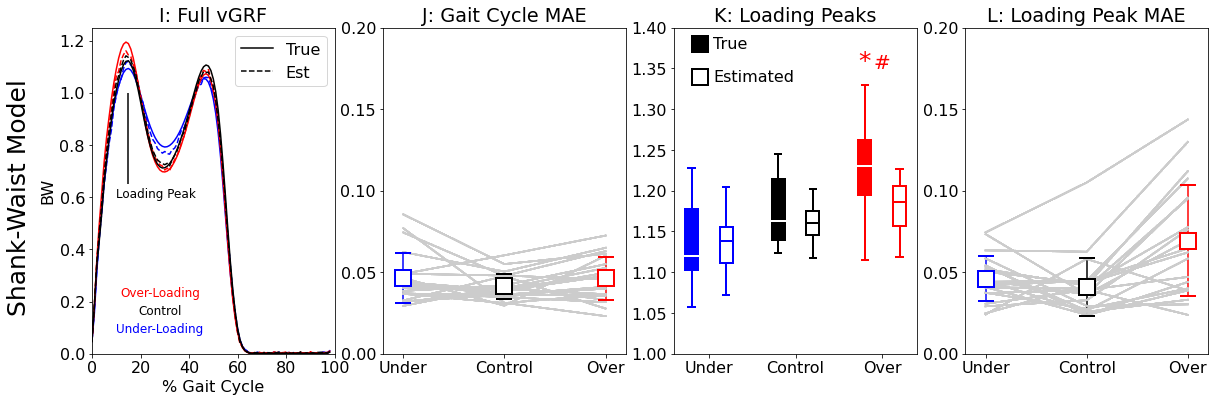

In [39]:
# Plot Results figures
fnt = 16
plt.rcParams.update({'font.size': fnt})
fig = plt.figure(figsize=(20,6))

# plot full vGRF waveform
ax1 = plt.subplot(141)
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '-b')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '--b')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '-r')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '--r')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '-k', label='True')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '--k', label='Est')
ax1.set_title('I: Full vGRF')
ax1.legend(loc='upper right')
ax1.set_ylim([0, 1.25])
ax1.set_xlim([0, 100])
ax1.set_xlabel('% Gait Cycle')
ax1.set_ylabel('BW')
ax1.text(28, 0.22, 'Over-Loading', c='r', ha='center', fontsize=12)
ax1.text(28, 0.15, 'Control', c='k', ha='center', fontsize=12)
ax1.text(28, 0.08, 'Under-Loading', c='b', ha='center', fontsize=12)
ax1.vlines(15, 0.65, 1)
ax1.text(10, 0.60, 'Loading Peak', fontsize=12)
ax1.text(-30, 0.60, 'Shank-Waist Model', fontsize=25, ha='center', va='center', rotation='vertical')


# plot predicted & true peaks
ax2 = plt.subplot(143)
ht = 0.5
p = 0

# under
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'under'].vGRF, 
            positions=[0.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'b', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'under'].vGRF, 
            positions=[1.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "b", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

# control
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'control'].vGRF, 
            positions=[1.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'k', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'control'].vGRF, 
            positions=[2.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "k", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

# over
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'over'].vGRF, 
            positions=[2.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'r', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})
ax2.boxplot(SubPkP[SubPkP['Cond'] == 'over'].vGRF, 
            positions=[3.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "r", "linewidth": 2},
            boxprops={"facecolor": 'white', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})

ax2.set_xticks(ticks=[1, 2, 3]) 
ax2.set_xticklabels(['Under', 'Control', 'Over'])
ax2.set_title('K: Loading Peaks')
ax2.set_xlim([0.6, 3.4])
ax2.set_ylim([1, 1.4])
# ax2.text(0.8, 1.20, '*', color='b', fontsize=25, ha='center')
ax2.text(2.8, 1.35, '*', color='r', fontsize=25, ha='center')
ax2.text(3, 1.35, '#', color='r', fontsize=20, ha='center')
ax2.plot(0.9, 1.38, 'sk', mfc='k', ms=16, mew=2)
ax2.text(1.05, 1.38, 'True', va='center')
ax2.plot(0.9, 1.34, 'sk', mfc='w', ms=16, mew=2)
ax2.text(1.05, 1.34, 'Estimated', va='center')


# Plot Stance Average Error 
ax=plt.subplot(142)
for k in range(len(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'])):
  ax.plot([1,2,3], [np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1), 
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1), 
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1)], 
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax.errorbar([1], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([2], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([3], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax.set_xticks([1,2,3])
ax.set_xticklabels(['Under', 'Control', 'Over'])
ax.set_xlim([0.8, 3.2])
ax.set_ylim([0, 0.2])
ax.set_yticks([0,0.05,0.10, 0.15, 0.2])
ax.set_title('J: Gait Cycle MAE')

# plot peak average error
ax4=plt.subplot(144)
for k in range(len(SubPkT[SubPkT['Cond'] == 'control'])):
  ax4.plot([1,2,3], [SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF, 
                    SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF, 
                    SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF], 
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax4.errorbar([1], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([2], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([3], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax4.set_xticks([1,2,3])
ax4.set_xticklabels(['Under', 'Control', 'Over'])
ax4.set_xlim([0.8, 3.2])
ax4.set_ylim([0, 0.2])
ax4.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax4.set_title('L: Loading Peak MAE')
plt.savefig('SW_sensitivity.png')

In [40]:
# output average errors by condition
Ue = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('GC Under MAE:', round(100*Ue, 2), ' %BW')
print('GC Control MAE:', round(100*Ce, 2), ' %BW')
print('GC Over MAE:', round(100*Oe, 2), ' %BW')

Ue = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('GC Under MAE:', round(100*Ue, 2), ' %BW')
print('GC Control MAE:', round(100*Ce, 2), ' %BW')
print('GC Over MAE:', round(100*Oe, 2), ' %BW')
print(' ')

Ue = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Pk Under MAE:', round(100*Ue, 2), ' %BW')
print('Pk Control MAE:', round(100*Ce, 2), ' %BW')
print('Pk Over MAE:', round(100*Oe, 2), ' %BW')

Ue = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Pk Under RMSE:', round(100*Ue, 2), ' %BW')
print('Pk Control RMSE:', round(100*Ce, 2), ' %BW')
print('Pk Over RMSE:', round(100*Oe, 2), ' %BW')


GC Under MAE: 4.65  %BW
GC Control MAE: 4.13  %BW
GC Over MAE: 4.63  %BW
GC Under MAE: 5.48  %BW
GC Control MAE: 4.83  %BW
GC Over MAE: 5.51  %BW
 
Pk Under MAE: 4.6  %BW
Pk Control MAE: 4.12  %BW
Pk Over MAE: 6.94  %BW
Pk Under RMSE: 5.53  %BW
Pk Control RMSE: 4.88  %BW
Pk Over RMSE: 8.22  %BW


# output the model

In [41]:
# locate model object
model = 'W' # waist only model
print(AggMLP[model][0]['Model'].get_params())
import joblib
fn = 'MLPmodel_' + model
joblib.dump(AggMLP[model][0]['Model'], fn, compress=0) # save model

# get method signature (data structure/method call, return data structure)
# more info on the model i/o: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlp+regressor#sklearn.neural_network.MLPRegressor

# list of dependencies
# model
# sklearn.neural_network.MLPRegressor
# processing
# all included above (see Import Libraries in the 1st code section above)

# original data used for figure(s)
# SQL database: 'steps.db' at https://drive.google.com/file/d/1CkkA35T394Hb8xVRLwBQTwq4BcDTqZPQ/view?usp=sharing
# CSV files in this folder: https://drive.google.com/drive/folders/1XUKsO2lV0NqlmhoU67xmjyN1tqKGkab_?usp=sharing 

# pre-processing code & steps
# all included in code above

{'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': [200], 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


['MLPmodel_W']

# Check output for 1 trial

In [42]:
mdl = AggMLP[model][1]['Model']
T = AggMLP[model][1]['True']
P = mdl.predict(AggMLP[model][1]['Test Input'])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


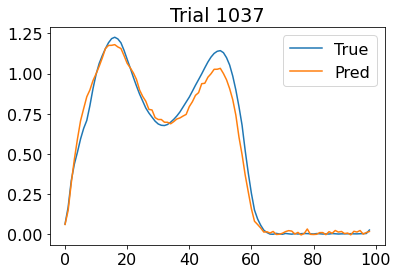

In [43]:
v = random.randint(1, len(P))
plt.plot(T[v,:], label='True')
plt.plot(P[v,:], label='Pred')
plt.title('Trial ' + str(v))
plt.legend()
plt.show()